In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geoplot as gplt
import shapefile
import osr
import requests
import io

from urllib.request import urlopen
from zipfile import ZipFile
from shapely.geometry import shape, Point, Polygon


%matplotlib inline

In [2]:
## url04 = 'https://www2.census.gov/geo/tiger/TIGER2010/TABBLOCK/2010/tl_2010_04_tabblock10.zip'
## zipfile = ZipFile(StringIO(urlopen(url04).read()))
zipfile01 = ZipFile('tl_2010_01_tabblock10.zip', 'r')

filenames01 = [y for y in sorted(zipfile01.namelist())
                 for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)]
## filenames01
## ['tl_2010_01_tabblock10.dbf','tl_2010_01_tabblock10.prj','tl_2010_01_tabblock10.shp','tl_2010_01_tabblock10.shx']

dbf01, prj01, shp01, shx01 = [io.BytesIO(zipfile01.read(filename)) for filename in filenames01]
## type(dbf01) 
## _io.BytesIO

r = shapefile.Reader(shp=shp01, shx=shx01, dbf=dbf01)
r.numRecords

252266

In [3]:
attributes, geometry = [], []

field_names = [field[0] for field in r.fields[1:]]

for row in r.shapeRecords():
    geometry.append(shape(row.shape.__geo_interface__))
    attributes.append(dict(zip(field_names,row.record)))

In [4]:
row.shape.__geo_interface__

{'type': 'Polygon',
 'coordinates': (((-87.609262, 34.156732),
   (-87.60923199999999, 34.15734),
   (-87.60916999999999, 34.157368999999996),
   (-87.60896199999999, 34.157393),
   (-87.609005, 34.157283),
   (-87.609123, 34.157092999999996),
   (-87.609195, 34.156960999999995),
   (-87.609262, 34.156732)),)}

In [5]:
prj = io.TextIOWrapper(prj01, encoding='utf-8')
proj4 = osr.SpatialReference(prj.read()).ExportToProj4()

In [6]:
gdf = gpd.GeoDataFrame(data=attributes, geometry=geometry, crs=proj4)
gdf[['INTPTLON10', 'INTPTLAT10']] = gdf[['INTPTLON10', 'INTPTLAT10']].apply(pd.to_numeric)
gdf.sort_values(['COUNTYFP10', 'BLOCKCE10', 'TRACTCE10'], ascending=[True, True, True], inplace=True)
gdf.reset_index(drop=True, inplace=True)

In [7]:
pop01 = pd.read_csv('DECENNIALSF12010.P1_data_with_overlays_2020-08-31T140516.csv', header=1)
pop01['GEOID10'] = pop01['id'].map(lambda x: x[9:])
## cols = pop01.columns.tolist()   ## ['id', 'Geographic Area Name', 'Total', 'GEOID10']
pop01 = pop01[['id', 'Geographic Area Name', 'GEOID10', 'Total']]

In [8]:
gdf01 = pd.merge(gdf, pop01, on='GEOID10')
geodata = gdf01[['COUNTYFP10', 'GEOID10', 'BLOCKCE10', 'geometry', 'Total', 'INTPTLON10', 'INTPTLAT10', 'Geographic Area Name']]
geodata['count'] = 1
geodata.head()

/home/jinli/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:849: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,COUNTYFP10,GEOID10,BLOCKCE10,geometry,Total,INTPTLON10,INTPTLAT10,Geographic Area Name,count
0,001,010010201001000,1000,"POLYGON ((-86.48644 32.47090, -86.48572 32.470...",61,-86.480959,32.469683,"Block 1000, Block Group 1, Census Tract 201, A...",1
1,001,010010202001000,1000,"POLYGON ((-86.46817 32.48742, -86.46824 32.487...",318,-86.475232,32.483304,"Block 1000, Block Group 1, Census Tract 202, A...",1
2,001,010010203001000,1000,"POLYGON ((-86.45356 32.48934, -86.46731 32.489...",2,-86.460002,32.490375,"Block 1000, Block Group 1, Census Tract 203, A...",1
3,001,010010204001000,1000,"POLYGON ((-86.45308 32.48935, -86.45356 32.489...",0,-86.449104,32.491296,"Block 1000, Block Group 1, Census Tract 204, A...",1
4,001,010010205001000,1000,"POLYGON ((-86.41317 32.45993, -86.41168 32.459...",0,-86.412197,32.458661,"Block 1000, Block Group 1, Census Tract 205, A...",1


In [9]:
geodata['LON*POP'] = geodata['Total']*geodata['INTPTLON10']
geodata['LAT*POP'] = geodata['Total']*geodata['INTPTLAT10']

/home/jinli/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:849: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [10]:
geodata.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 252266 entries, 0 to 252265
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   COUNTYFP10            252266 non-null  object  
 1   GEOID10               252266 non-null  object  
 2   BLOCKCE10             252266 non-null  object  
 3   geometry              252266 non-null  geometry
 4   Total                 252266 non-null  int64   
 5   INTPTLON10            252266 non-null  float64 
 6   INTPTLAT10            252266 non-null  float64 
 7   Geographic Area Name  252266 non-null  object  
 8   count                 252266 non-null  int64   
 9   LON*POP               252266 non-null  float64 
 10  LAT*POP               252266 non-null  float64 
dtypes: float64(4), geometry(1), int64(2), object(4)
memory usage: 23.1+ MB


In [11]:
s01_df = geodata.groupby(['COUNTYFP10'])['Total', 'LON*POP', 'LAT*POP', 'count', 'INTPTLON10', 'INTPTLAT10'].sum().reset_index()
s01_df

/home/jinli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,COUNTYFP10,Total,LON*POP,LAT*POP,count,INTPTLON10,INTPTLAT10
0,001,54571,-4.720074e+06,1.773579e+06,1887,-163348.435237,61351.218196
1,003,182265,-1.599603e+07,5.568000e+06,8628,-757144.699179,263813.727429
2,005,27457,-2.342355e+06,8.743417e+05,1820,-155286.922993,57956.290658
3,007,22915,-1.996530e+06,7.569036e+05,1777,-154821.177900,58686.214615
4,009,57322,-4.963592e+06,1.946382e+06,2750,-238043.958681,93423.158141
...,...,...,...,...,...,...,...
62,125,194656,-1.703634e+07,6.465334e+06,9004,-787900.314305,299174.372619
63,127,67023,-5.848023e+06,2.267714e+06,4274,-373035.288027,144523.919648
64,129,17581,-1.550402e+06,5.522257e+05,1818,-160242.394664,57042.962132
65,131,11670,-1.019730e+06,3.734371e+05,1139,-99493.464662,36446.126852


In [12]:
s01_df['w.LON'] = s01_df['LON*POP']/s01_df['Total']
s01_df['w.LAT'] = s01_df['LAT*POP']/s01_df['Total']
s01_df['LON'] = s01_df['INTPTLON10']/s01_df['count']
s01_df['LAT'] = s01_df['INTPTLAT10']/s01_df['count']

s01_df = s01_df[['COUNTYFP10', 'Total', 'w.LON', 'w.LAT', 'count', 'LON', 'LAT']]

In [13]:
u_s01 = s01_df[['COUNTYFP10', 'LON', 'LAT']]
w_s01 = s01_df[['COUNTYFP10', 'w.LON', 'w.LAT']].rename({'w.LON': 'LON', 'w.LAT': 'LAT'}, axis=1)

w_s01['Weighted'] = 1
u_s01['Weighted'] = 0

s01 = pd.concat([w_s01, u_s01]).sort_values(by='COUNTYFP10', ascending=True).reset_index(drop=True)

/home/jinli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:
geometry = [Point(xy) for xy in zip(s01['LON'], s01['LAT'])]
geometry[:3]

In [15]:
cent01 = gpd.GeoDataFrame(s01, geometry=geometry)
cent01.head()

,COUNTYFP10,LON,LAT,Weighted,geometry
0,001,-86.494186,32.500389,1,POINT (-86.49419 32.50039)
1,001,-86.565149,32.512569,0,POINT (-86.56515 32.51257)
2,003,-87.762466,30.548923,1,POINT (-87.76247 30.54892)
3,003,-87.754369,30.576464,0,POINT (-87.75437 30.57646)
4,005,-85.309929,31.844037,1,POINT (-85.30993 31.84404)


In [16]:
cc01001 = cent01[cent01.COUNTYFP10=='001']
c001 = geodata[geodata.COUNTYFP10=='001']

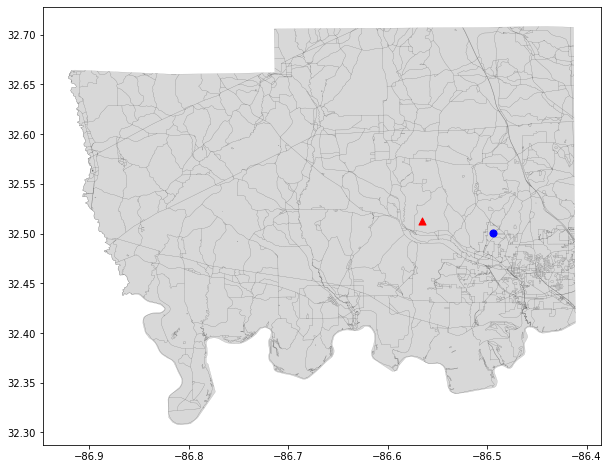

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
c001.plot(ax=ax, alpha=0.3, color='grey', linewidth=0.2, edgecolor='black')
cc01001[cc01001.Weighted==1].plot(ax=ax, markersize=50, color='blue', marker='o')
cc01001[cc01001.Weighted==0].plot(ax=ax, markersize=50, color='red', marker='^')
#https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

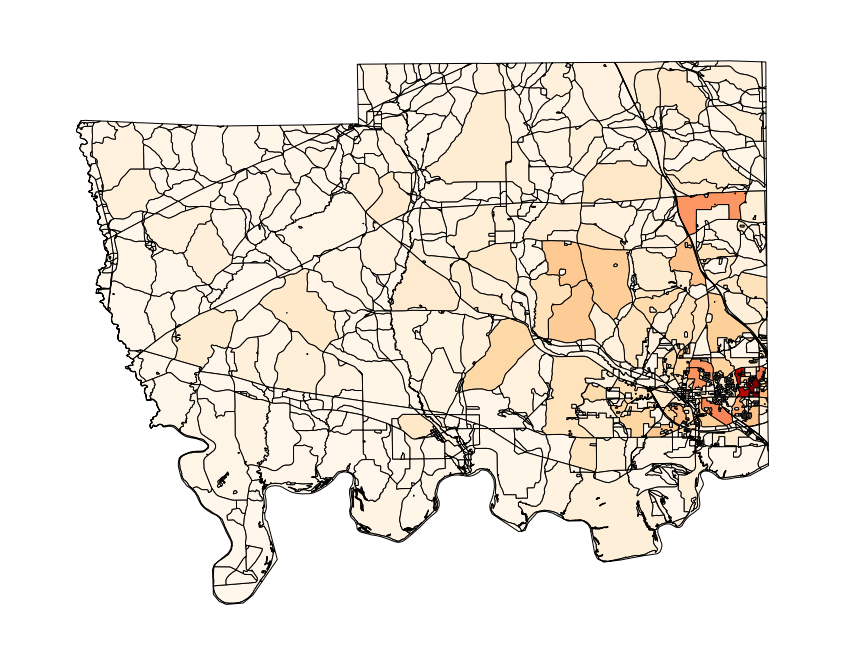

In [18]:
c001 = geodata[geodata.COUNTYFP10=='001']
PALETTE = 'OrRd'
gplt.choropleth(c001, hue = geodata['Total'], cmap = PALETTE, figsize = (15,12))
#https://towardsdatascience.com/plotting-geographical-data-with-geopandas-338cc7e17e4e

In [38]:
countypairs = pd.read_csv('county-pair-list.txt')
new = countypairs['COUNTYPAIR_ID'].str.split("-", n = 1, expand = True)
countypairs['state-county FIPS1'] = new[0]
countypairs['state-county FIPS2'] = new[1]
countypairs = countypairs[['COUNTYPAIR_ID', 'COUNTY', 'state-county FIPS1', 'state-county FIPS2']]

In [39]:
# countypairs.shape                                  ##(2362, 4)
# countypairs.COUNTYPAIR_ID.unique().size            ## 1181
countypairs.drop_duplicates(subset='COUNTYPAIR_ID', inplace = True)
countypairs.reset_index(drop=True, inplace=True)
# countypairs.shape                                  ##(1181, 4)

In [40]:
countypairs.head(20)

,COUNTYPAIR_ID,COUNTY,state-county FIPS1,state-county FIPS2
0,01003-12033,1003,01003,12033
1,01005-13239,1005,01005,13239
2,01017-13145,1017,01017,13145
3,01019-13233,1019,01019,13233
4,01023-28023,1023,01023,28023
5,01023-28153,1023,01023,28153
6,01029-13045,1029,01029,13045
7,01029-13143,1029,01029,13143
8,01039-12091,1039,01039,12091
9,01039-12131,1039,01039,12131


In [3]:
polys1 = gpd.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]), Polygon([(2,2), (4,2), (4,4), (2,4)])])
polys2 = gpd.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]), Polygon([(3,3), (5,3), (5,5), (3,5)])])

df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1':[1,2]})
df2 = gpd.GeoDataFrame({'geometry': polys2, 'df2':[1,2]})

In [4]:
df1

,geometry,df1
0,"POLYGON ((0.00000 0.00000, 2.00000 0.00000, 2....",1
1,"POLYGON ((2.00000 2.00000, 4.00000 2.00000, 4....",2


In [5]:
polys1

0    POLYGON ((0.00000 0.00000, 2.00000 0.00000, 2....
1    POLYGON ((2.00000 2.00000, 4.00000 2.00000, 4....
dtype: geometry